In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
model_path = "runs/20241115-172401/model_1990000.pt"
model = QNetwork(model_path=model_path)

action_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']
activation_layers = [1, 3, 5, 8]

/home/jacob/DRL-CAV/.venv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded model: 20241115-172401-1990000


In [4]:
def prepare_probe(concept, model, layer, max_size=10000):
    concept.prepare_data(env_steps, max_size=max_size)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)

    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_weights = lr.coef_[0]
    norm_direction = flat_weights #/ np.linalg.norm(flat_weights)

    return lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy

In [5]:
class ModelDirectionOptimizer(nn.Module):
    def __init__(self, model, direction, layer):
        super().__init__()
        self.direction = direction
        self.layer = layer
        self.model_activations = model.network[:layer + 1]

    def forward(self, x):
        activations = self.forward_activations(x)
        dot_product = self.forward_direction(activations)
        return dot_product
    
    def forward_activations(self, x):
        if x.shape[1] == x.shape[2]:
            x = x.permute(0, 3, 1, 2)
            
        activations = self.model_activations(x)
        return activations.flatten(start_dim=1)
    
    def forward_direction(self, activations):
        return activations @ self.direction

Probe accuracy: 0.94
torch.Size([1, 84, 84, 3])


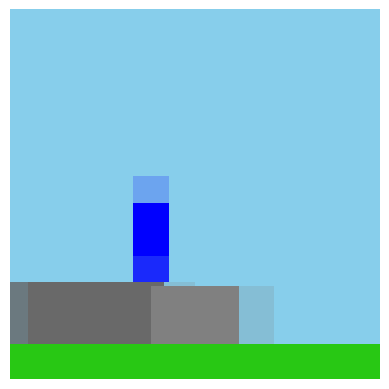

In [6]:
concept = concept_instances['Visible bullet']
layer = 5
maximize = 1 # 1 for maximizing, -1 for minimizing

lr, direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)
print(f"Probe accuracy: {probe_accuracy}")
dot_net = ModelDirectionOptimizer(model, torch.tensor(direction.flatten()).float(), layer)
example_obs = torch.tensor(concept.test_obs[-maximize]).unsqueeze(0).float()
original_obs = example_obs.clone()
print(example_obs.shape)
plt.imshow(example_obs[0].int())
plt.axis('off')
plt.show()

tensor([1826.1252], grad_fn=<MvBackward0>)
tensor([1942.6726], grad_fn=<MvBackward0>)


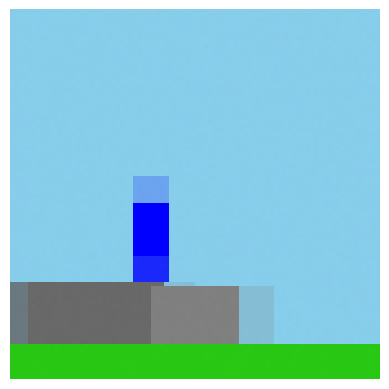

In [7]:
# TODO: Make dot be a classifier instead, ranging from 0 to 1
# See if bias/threshold can be extracted from sklearn model
# After this, consider autoencoder visualization

lr = 1
steps = 100
alpha = 1.0

example_obs.requires_grad = True
original_dot = dot_net(example_obs)
print(original_dot)
optimizer = torch.optim.Adam([example_obs], lr=lr)
for i in range(steps):
    # Add random noise to the image
    example_obs.data += torch.randn_like(example_obs) * 0.1
    optimizer.zero_grad()
    dot = dot_net(example_obs)
    loss = -maximize * dot + alpha * torch.norm(example_obs - original_obs, p=1)
    loss.backward()
    optimizer.step()
    
    # Clamp the image values to be between 0 and 255
    example_obs.data = example_obs.data.clamp(0, 255)
print(dot)
plt.imshow(example_obs[0].int())
plt.axis('off')
plt.show()